## Sales Forecasting

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
import statsmodels.api as sm

### Load and preprocess data

In [2]:
df = pd.read_excel('../power bi competition/Order Data/Order Data.xlsx')
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,Lon,Lat,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,New Zealand,Queenstown,168.6626,-45.0312,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,New Zealand,Queenstown,168.6626,-45.0312,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,New Zealand,Christchurch,172.6362,-43.5321,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,New Zealand,Queenstown,168.6626,-45.0312,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,New Zealand,Queenstown,168.6626,-45.0312,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       8292 non-null   object        
 1   Order Date     8292 non-null   datetime64[ns]
 2   Ship Date      8292 non-null   datetime64[ns]
 3   Ship Mode      8292 non-null   object        
 4   Customer ID    8292 non-null   object        
 5   Customer Name  8292 non-null   object        
 6   Segment        8292 non-null   object        
 7   Country        8292 non-null   object        
 8   City           8292 non-null   object        
 9   Lon            8292 non-null   float64       
 10  Lat            8292 non-null   float64       
 11  Product ID     8292 non-null   object        
 12  Category       8292 non-null   object        
 13  Sub-Category   8292 non-null   object        
 14  Product Name   8292 non-null   object        
 15  Sales          8292 n

In [4]:
df.describe()

,Order Date,Ship Date,Lon,Lat,Sales,Quantity,Discount,Profit
count,8292,8292,8292.000000,8292.000000,8292.000000,8292.000000,8292.000000,8292.000000
mean,2016-01-08 09:34:17.887120128,2016-01-12 08:58:31.432706304,172.904487,-41.334067,232.083721,3.788471,0.156333,29.780882
min,2014-01-03 00:00:00,2014-01-07 00:00:00,168.353800,-46.413200,0.444000,1.000000,0.000000,-6599.978000
25%,2015-02-09 00:00:00,2015-02-13 00:00:00,171.210800,-44.397000,17.340000,2.000000,0.000000,1.724800
50%,2016-01-22 00:00:00,2016-01-26 12:00:00,173.284000,-41.286500,55.136000,3.000000,0.200000,8.790600
75%,2016-11-21 00:00:00,2016-11-25 00:00:00,174.776200,-37.687800,211.960000,5.000000,0.200000,29.955150
max,2017-08-27 00:00:00,2017-09-01 00:00:00,176.165100,-36.848500,22638.480000,14.000000,0.800000,8399.976000
std,NaN,NaN,2.357320,3.229633,630.549633,2.216618,0.207112,232.323487


In [5]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'Lon', 'Lat',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [6]:
sorted(df['City'].unique())

['Auckland',
 'Christchurch',
 'Dunedin',
 'Greymouth',
 'Hamilton',
 'Invercargill',
 'Nelson',
 'New Plymouth',
 'Queenstown',
 'Tauranga',
 'Timaru',
 'Wellington']

New Zealand

In [97]:
# New Zealand daily sales
daily_sales = df.groupby('Order Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'
}).reset_index()

daily_sales.set_index('Order Date', inplace=True)
daily_sales

,Sales,Quantity,Profit,Discount
Order Date,,,,
2014-01-03,16.448,2,5.5512,0.200000
2014-01-04,288.060,8,-65.9901,0.400000
2014-01-05,19.536,3,4.8840,0.200000
2014-01-06,4407.100,30,1358.0524,0.000000
2014-01-07,87.158,10,-71.9621,0.700000
...,...,...,...,...
2017-08-23,4590.344,28,358.5460,0.200000
2017-08-24,685.056,15,77.4060,0.200000
2017-08-25,361.988,12,-17.1108,0.260000


In [98]:
# fill the date without sales data by 0 value
full_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')
daily_sales = daily_sales.reindex(full_range, fill_value=0)
daily_sales.index.name = 'Order Date'
daily_sales

,Sales,Quantity,Profit,Discount
Order Date,,,,
2014-01-03,16.448,2,5.5512,0.200000
2014-01-04,288.060,8,-65.9901,0.400000
2014-01-05,19.536,3,4.8840,0.200000
2014-01-06,4407.100,30,1358.0524,0.000000
2014-01-07,87.158,10,-71.9621,0.700000
...,...,...,...,...
2017-08-23,4590.344,28,358.5460,0.200000
2017-08-24,685.056,15,77.4060,0.200000
2017-08-25,361.988,12,-17.1108,0.260000


### Decomposition of time series

In [99]:
# STL decomposition
stl = STL(daily_sales['Sales'], period = 7)
stl_result = stl.fit()

In [100]:
# Calculate the average
sales_mean = daily_sales['Sales'].mean()
trend_mean = stl_result.trend.mean()
seasonal_mean = stl_result.seasonal.mean()
residual_mean = stl_result.resid.mean()

print(f"Overall Sales Mean: {sales_mean}")
print(f"Trend Mean: {trend_mean}")
print(f"Seasonality Mean: {seasonal_mean}")
print(f"Residual (Noise) Mean: {residual_mean}")

Overall Sales Mean: 1443.6895808702177
Trend Mean: 1444.0931520357137
Seasonality Mean: -0.636209386043722
Residual (Noise) Mean: 0.23263822054769237


In [101]:
# Outlier detection
residual_std = stl_result.resid.std()
threshold = 3 * residual_std  # set 3 times of residual as threshould
outliers = np.abs(stl_result.resid) > threshold
print(outliers)

Order Date
2014-01-03    False
2014-01-04    False
2014-01-05    False
2014-01-06    False
2014-01-07    False
              ...  
2017-08-23    False
2017-08-24    False
2017-08-25    False
2017-08-26    False
2017-08-27    False
Freq: D, Name: resid, Length: 1333, dtype: bool


Text(0.15, 0.95, 'STL')

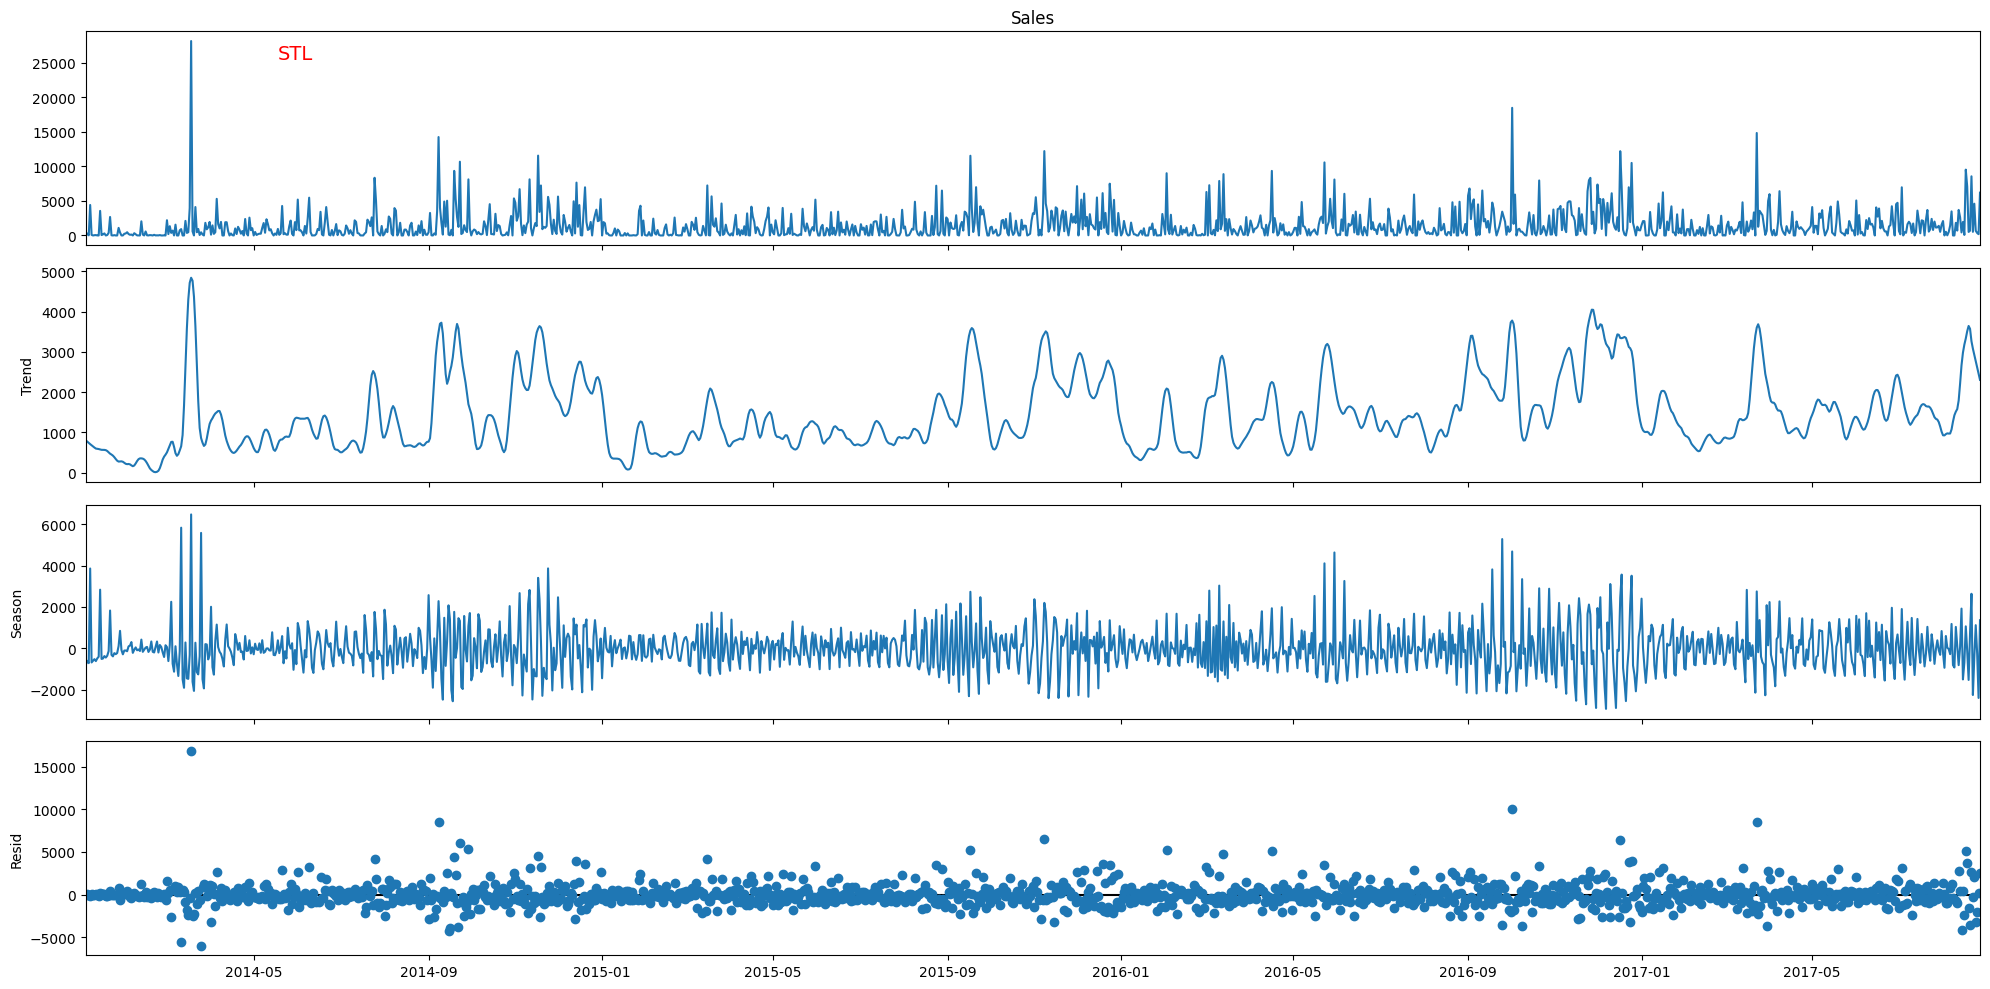

In [102]:
# Visualisation
plt.rcParams.update({'figure.figsize': (20,10)})
stl_result.plot().suptitle('STL', x=0.15, y=0.95, fontsize=14, color='red')

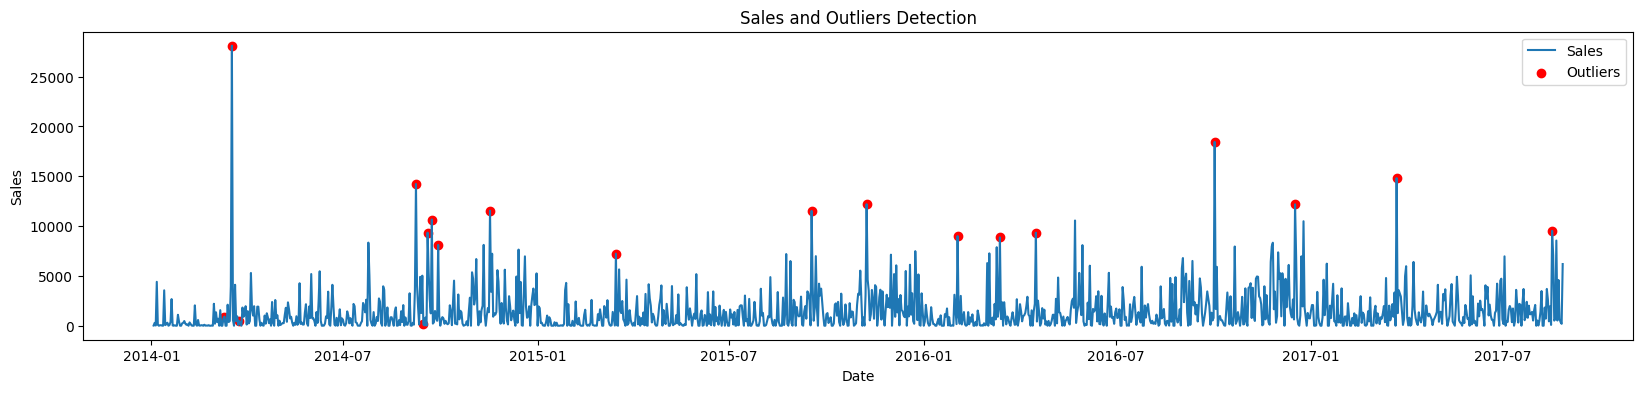

In [103]:
plt.figure(figsize=(20, 4))
plt.plot(daily_sales.index, daily_sales['Sales'], label='Sales')
plt.scatter(daily_sales.index[outliers], daily_sales['Sales'][outliers], color='red', label='Outliers')
plt.title('Sales and Outliers Detection')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Linear vs Exponential

In [104]:
# Linear VS Exponential
X = np.arange(len(stl_result.trend)).reshape(-1, 1)
y = stl_result.trend

# Linear fitting
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_trend = linear_model.predict(X)

# Exponential fitting
log_trend = np.log(y)
exp_model = linregress(X.flatten(), log_trend)
exp_trend = np.exp(exp_model.intercept + exp_model.slope * X.flatten())

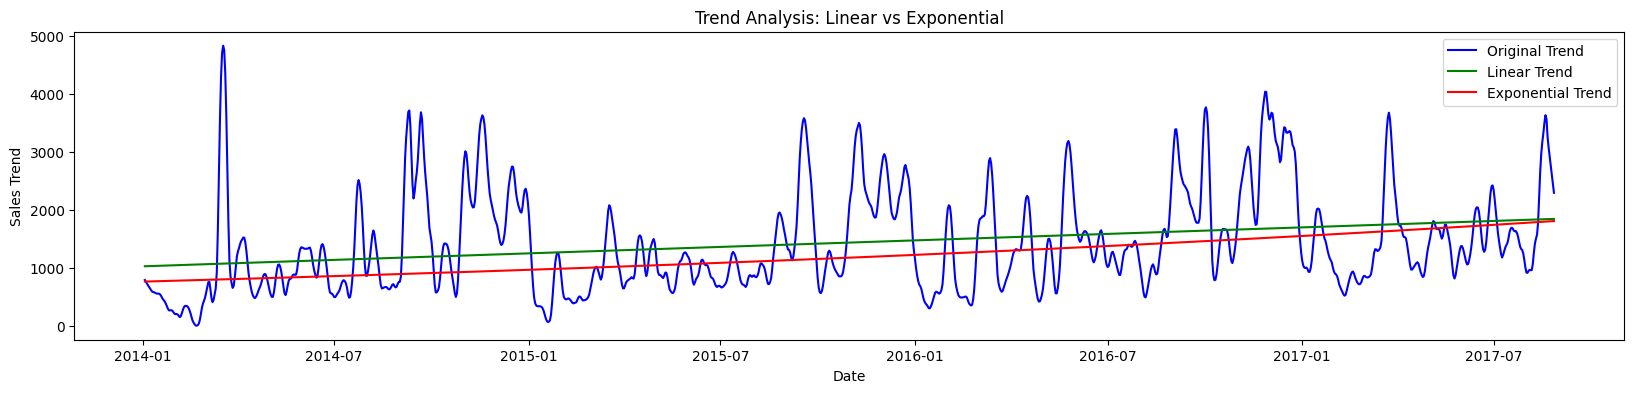

In [105]:
# Visualisation
plt.figure(figsize=(20, 4))
plt.plot(daily_sales.index, stl_result.trend, label='Original Trend', color='blue')
plt.plot(daily_sales.index, linear_trend, label='Linear Trend', color='green')
plt.plot(daily_sales.index, exp_trend, label='Exponential Trend', color='red')
plt.title('Linear vs Exponential')
plt.xlabel('Date')
plt.ylabel('Sales Trend')
plt.legend()
plt.show()

### Attributes of time series

Stationary vs Non-Stationary

In [106]:
# ADF test
adf_result = adfuller(daily_sales['Sales'])

# Print the result
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -5.41497061400774
p-value: 3.1504038283253062e-06
Critical Values 1%: -3.4353440094155756
Critical Values 5%: -2.8637454499962196
Critical Values 10%: -2.5679441928400135


The p value is far smaller than 0.05.
ADF statistic is smaller than all thresholds.
This time series is likely staionary.

### EDA

Autocorrelation & Partial correlation

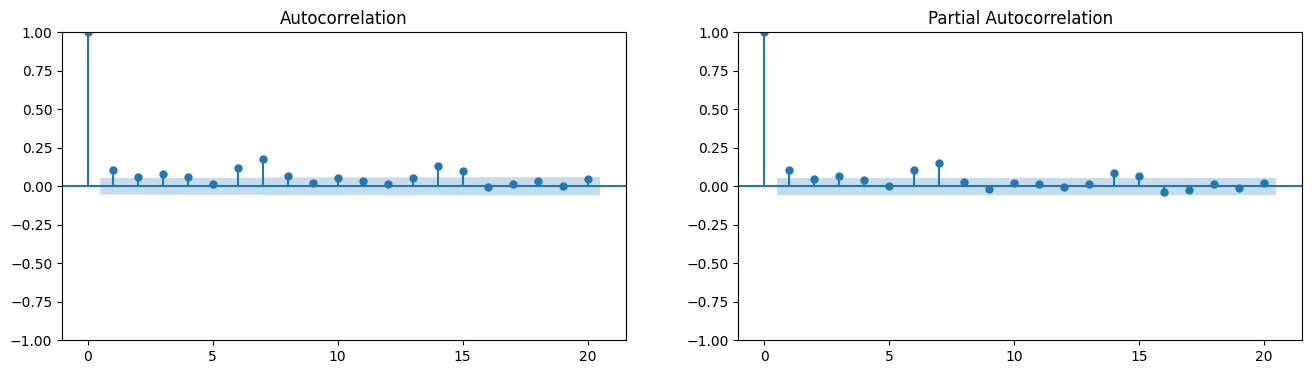

In [107]:
# ACF and PACF
plt.figure(figsize=(16, 4))
plt.subplot(121)
plot_acf(daily_sales['Sales'], lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(daily_sales['Sales'], lags=20, ax=plt.gca())
plt.show()

ACF and PACF show strong correlation is only at lag 1, but drops quickly and stay near 0 for the rest. The series is likely stationary without long-term autocorrelation.

### Forecasting - ARIMA

ARIMA - Autoregressive Integrated Moving Average

Training the model

In [195]:
# Split the data into training data and testing data
# set 2017-02-27 as split point
split_date = datetime(2017, 2, 27)

train_data = daily_sales[daily_sales.index <= split_date]
test_data = daily_sales[daily_sales.index > split_date]

print("Train data size:", train_data.shape)
print("Test data size:", test_data.shape)

Train data size: (1152, 4)
Test data size: (181, 4)


In [196]:
# STL decomposition
stl = STL(train_data['Sales'], period = 7)
stl_result = stl.fit()

In [197]:
# observed = trend + seasonal + residual
reconstructed = pd.concat([stl_result.seasonal, stl_result.trend, stl_result.resid, stl_result.observed], axis=1)
reconstructed.columns = ['seasonal', 'trend', 'residual', 'actual_values']
# Check 'actual_values = seasonal + trend + residual'
reconstructed['sum_check'] = reconstructed['seasonal']+reconstructed['trend']+reconstructed['residual']
train_data = reconstructed.copy()
train_data

,seasonal,trend,residual,actual_values,sum_check
Order Date,,,,,
2014-01-03,-778.150501,798.981638,-4.383137,16.448,16.448
2014-01-04,-601.335918,767.065203,122.330715,288.060,288.060
2014-01-05,-712.869874,736.311953,-3.906079,19.536,19.536
2014-01-06,3857.630500,706.576524,-157.107024,4407.100,4407.100
2014-01-07,-679.419439,677.618195,88.959243,87.158,87.158
...,...,...,...,...,...
2017-02-23,-405.789827,775.957250,-252.367423,117.800,117.800
2017-02-24,1292.865125,752.414229,-596.603354,1448.676,1448.676
2017-02-25,-356.944009,731.710661,55.725348,430.492,430.492


In [198]:
# Add exogenous variables
exog_train = daily_sales.loc[train_data.index, ['Quantity', 'Discount', 'Profit']]
exog_train

,Quantity,Discount,Profit
Order Date,,,
2014-01-03,2,0.200000,5.5512
2014-01-04,8,0.400000,-65.9901
2014-01-05,3,0.200000,4.8840
2014-01-06,30,0.000000,1358.0524
2014-01-07,10,0.700000,-71.9621
...,...,...,...
2017-02-23,16,0.066667,42.3700
2017-02-24,14,0.366667,249.3929
2017-02-25,10,0.400000,-19.3798


In [199]:
model_1 = pm.auto_arima(train_data['trend'],
                        exogenous = exog_train, 
                      start_p=1, start_q=1,
                      test='adf',       
                      max_p=4, max_q=4, 
                      m=7,              
                      d=1,           
                      seasonal=True,   
                      start_P=0, 
                      D=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=16085.462, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=13516.100, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=14198.983, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=15474.454, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=12565.351, Time=0.33 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=12886.381, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=12105.785, Time=0.62 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.76 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.76 sec


In [201]:
print(model_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1152
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 7)   Log Likelihood               -5824.128
Date:                            Thu, 05 Sep 2024   AIC                          11664.256
Time:                                    22:46:17   BIC                          11704.594
Sample:                                01-03-2014   HQIC                         11679.486
                                     - 02-27-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3107      0.054     43.175      0.000       2.206       2.416
ar.L2         -2.4473      0.101   

In [202]:
residuals = model_1.resid()

mse = np.mean(residuals**2)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 2234.824310082631
RMSE: 47.273928439284916


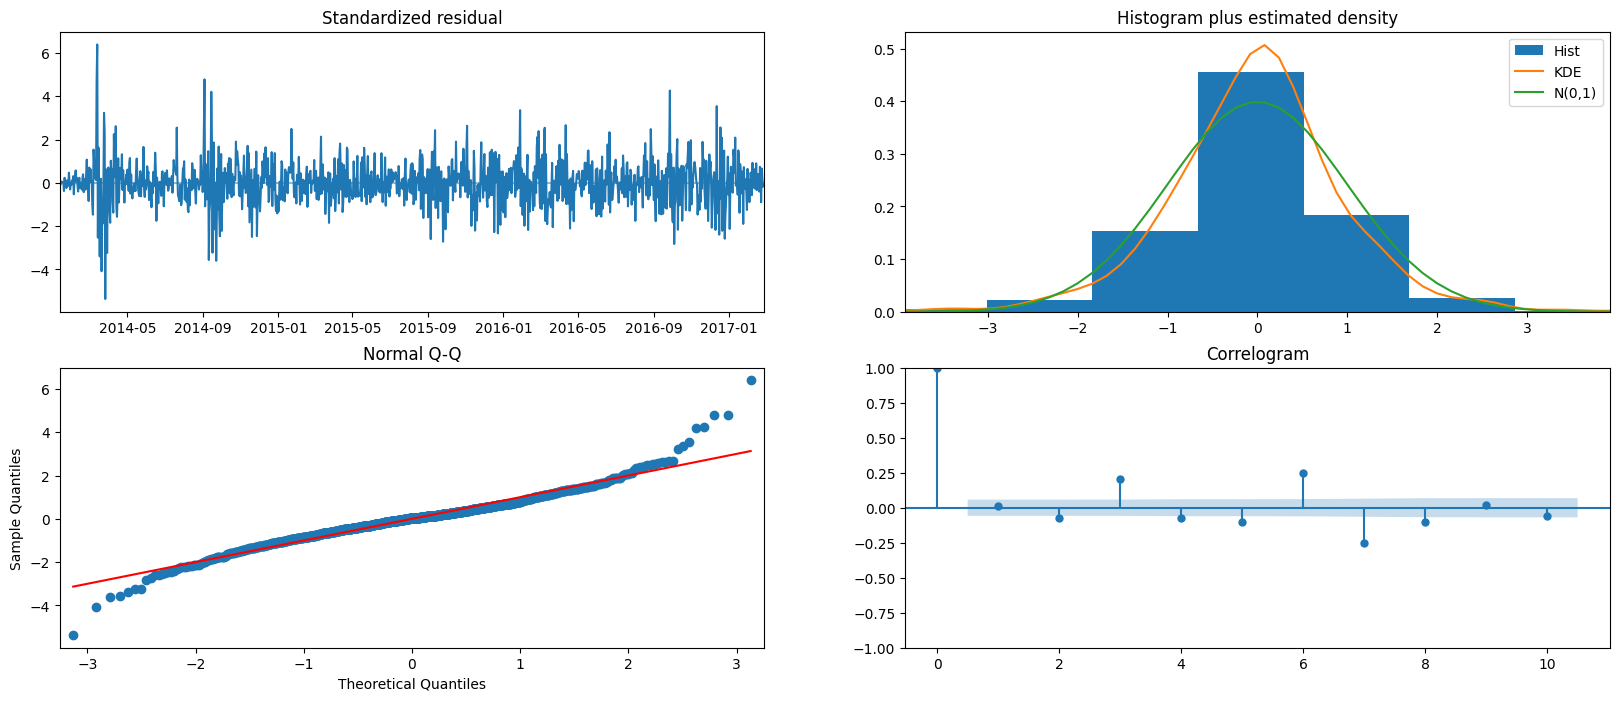

In [188]:
model_1.plot_diagnostics(figsize=(20,8))
plt.show()

<ul>
    <li>Top left: The residual errors seem to fluctuate around a mean of zero, somewhat uniform variance.</li>
    <li>Top Right: The density plot suggest an almost normal distribution with mean zero.
    <li>Bottom left: Q-Q plot. All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
    <li>Bottom Right: The Correlogram (ACF plot) shows the residual errors are not autocorrelated. 
</ul>

Testing the model

In [189]:
# Forecast
exog_test = test_data[['Quantity', 'Discount', 'Profit']]

n_periods = len(test_data)
fc, confint = model_1.predict(n_periods=n_periods, exogenous = exog_test, return_conf_int=True)
index_of_fc = np.arange(len(train_data['trend']), len(train_data['trend'])+n_periods)

# Attach forecasts to the test data
test_data['forecast'] = fc
test_data['upper_limit'] = [confint[i][1] for i in range(0,len(confint))]
test_data['lower_limit'] = [confint[i][0] for i in range(0,len(confint))]
test_data

C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\2513571764.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast'] = fc
C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\2513571764.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['upper_limit'] = [confint[i][1] for i in range(0,len(confint))]
C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\2513571764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Sales,Quantity,Profit,Discount,forecast,upper_limit,lower_limit
Order Date,,,,,,,
2017-02-28,17.620,3,8.2242,0.000000,684.895416,761.489273,608.301560
2017-03-01,0.000,0,0.0000,0.000000,658.239776,908.521610,407.957942
2017-03-02,1450.126,45,244.0397,0.263636,635.733348,1128.448051,143.018645
2017-03-03,2000.104,34,528.1881,0.085714,623.166895,1381.799296,-135.465506
2017-03-04,228.822,14,-33.9224,0.200000,625.241873,1647.192524,-396.708779
...,...,...,...,...,...,...,...
2017-08-23,4590.344,28,358.5460,0.200000,6.828008,54594.465136,-54580.809121
2017-08-24,685.056,15,77.4060,0.200000,3.820786,55034.783846,-55027.142275
2017-08-25,361.988,12,-17.1108,0.260000,1.693581,55477.969674,-55474.582511


In [190]:
# Get the last week's seasonal pattern from train_data
seasonal_pattern = train_data['seasonal'].tail(7).values  # Weekly seasonality

# Create new columns to store the forecast adjusted with seasonality
test_data['forecast_with_seasonal'] = test_data['forecast']
test_data['upper_limit_with_seasonal'] = test_data['upper_limit']
test_data['lower_limit_with_seasonal'] = test_data['lower_limit']

# Apply the weekly seasonal pattern to test_data
for i in range(len(test_data)):
    weekly_seasonal_value = seasonal_pattern[i % len(seasonal_pattern)]
    test_data['forecast_with_seasonal'].iloc[i] += weekly_seasonal_value

C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\200526325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast_with_seasonal'] = test_data['forecast']
C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\200526325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['upper_limit_with_seasonal'] = test_data['upper_limit']
C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\200526325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

C:\Users\Alvin Zhao\AppData\Local\Temp\ipykernel_10432\2800736613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['difference'] = test_data['forecast_with_seasonal'] - test_data['Sales']


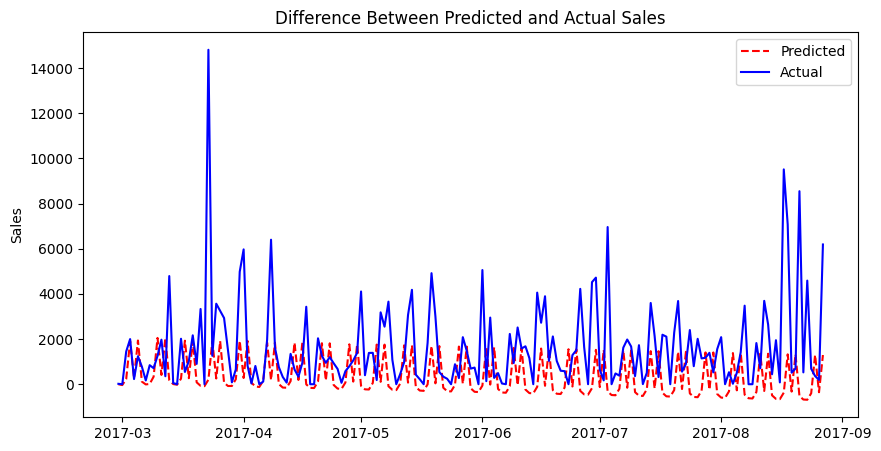

In [191]:
# Calculate the difference between the forecast and actual values
test_data['difference'] = test_data['forecast_with_seasonal'] - test_data['Sales']

plt.subplots(figsize=(10, 5))

plt.plot(test_data.index, test_data['forecast_with_seasonal'], color='red', linestyle='--', lw=1.5, label='Predicted')

plt.plot(test_data.index, test_data['Sales'], color='blue', linestyle='-', lw=1.5, label='Actual')

# # Fill the area between the upper and lower limits (confidence interval)
# plt.fill_between(test_data.index, 
#                  test_data['lower_limit_with_seasonal'], 
#                  test_data['upper_limit_with_seasonal'], 
#                  color='grey', alpha=.3, label='Confidence Interval')

plt.ylabel('Sales')
plt.title('Difference Between Predicted and Actual Sales')
plt.legend()

plt.show()


Forecasting

In [192]:
stl = STL(daily_sales['Sales'], period = 7)
stl_result = stl.fit()

In [193]:
# observed = trend + seasonal + residual
reconstructed = pd.concat([stl_result.seasonal, stl_result.trend, stl_result.resid, stl_result.observed], axis=1)
reconstructed.columns = ['seasonal', 'trend', 'residual', 'actual_values']
# Check 'actual_values = seasonal + trend + residual'
reconstructed['sum_check'] = reconstructed['seasonal']+reconstructed['trend']+reconstructed['residual']
reconstructed

,seasonal,trend,residual,actual_values,sum_check
Order Date,,,,,
2014-01-03,-778.150501,798.981638,-4.383137,16.448,16.448
2014-01-04,-601.335918,767.065203,122.330715,288.060,288.060
2014-01-05,-712.869874,736.311953,-3.906079,19.536,19.536
2014-01-06,3857.630500,706.576524,-157.107024,4407.100,4407.100
2014-01-07,-679.419439,677.618195,88.959243,87.158,87.158
...,...,...,...,...,...
2017-08-23,-417.797332,2920.662907,2087.478424,4590.344,4590.344
2017-08-24,1121.849330,2766.122242,-3202.915572,685.056,685.056
2017-08-25,-237.982057,2606.968729,-2006.998672,361.988,361.988


In [194]:
# Add exogenous variables
exog = daily_sales.loc[daily_sales.index, ['Quantity', 'Discount', 'Profit']]
exog

,Quantity,Discount,Profit
Order Date,,,
2014-01-03,2,0.200000,5.5512
2014-01-04,8,0.400000,-65.9901
2014-01-05,3,0.200000,4.8840
2014-01-06,30,0.000000,1358.0524
2014-01-07,10,0.700000,-71.9621
...,...,...,...
2017-08-23,28,0.200000,358.5460
2017-08-24,15,0.200000,77.4060
2017-08-25,12,0.260000,-17.1108


In [166]:
model_2 = pm.auto_arima(reconstructed['trend'], 
                        exogenous = exog,
                      start_p=1, start_q=1,
                      test='adf',       
                      max_p=4, max_q=4, 
                      m=7,              
                      d=1,           
                      seasonal=True,   
                      start_P=0, 
                      D=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=16085.462, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=13516.100, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=14198.983, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=15474.454, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=12565.351, Time=0.30 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=12886.381, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=12105.785, Time=0.58 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.68 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.70 sec


In [203]:
print(model_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1152
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 7)   Log Likelihood               -5824.128
Date:                            Thu, 05 Sep 2024   AIC                          11664.256
Time:                                    22:52:08   BIC                          11704.594
Sample:                                01-03-2014   HQIC                         11679.486
                                     - 02-27-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3107      0.054     43.175      0.000       2.206       2.416
ar.L2         -2.4473      0.101   

In [204]:
residuals = model_2.resid()

mse = np.mean(residuals**2)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 2234.824310082631
RMSE: 47.273928439284916


In [167]:
# Forecast for the next 6 months (180 days)
n_periods = 180
forecast, conf_int = model_2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(reconstructed.index[-1] , periods=n_periods, freq='D')

In [178]:
# Add seasonality from the last known seasonality pattern in train data (for 7-day weekly seasonality)
seasonal_pattern = reconstructed['seasonal'].tail(7).values  
seasonality = [seasonal_pattern[i % len(seasonal_pattern)] for i in range(n_periods)]
forecast_seasonality = forecast + seasonality

forecast_df = pd.DataFrame({
    'forecast': forecast,  
    'forecast_s': forecast_seasonality 
}, index=index_of_fc)
conf_int_df = pd.DataFrame(conf_int, index=index_of_fc, columns=['lower_limit', 'upper_limit'])

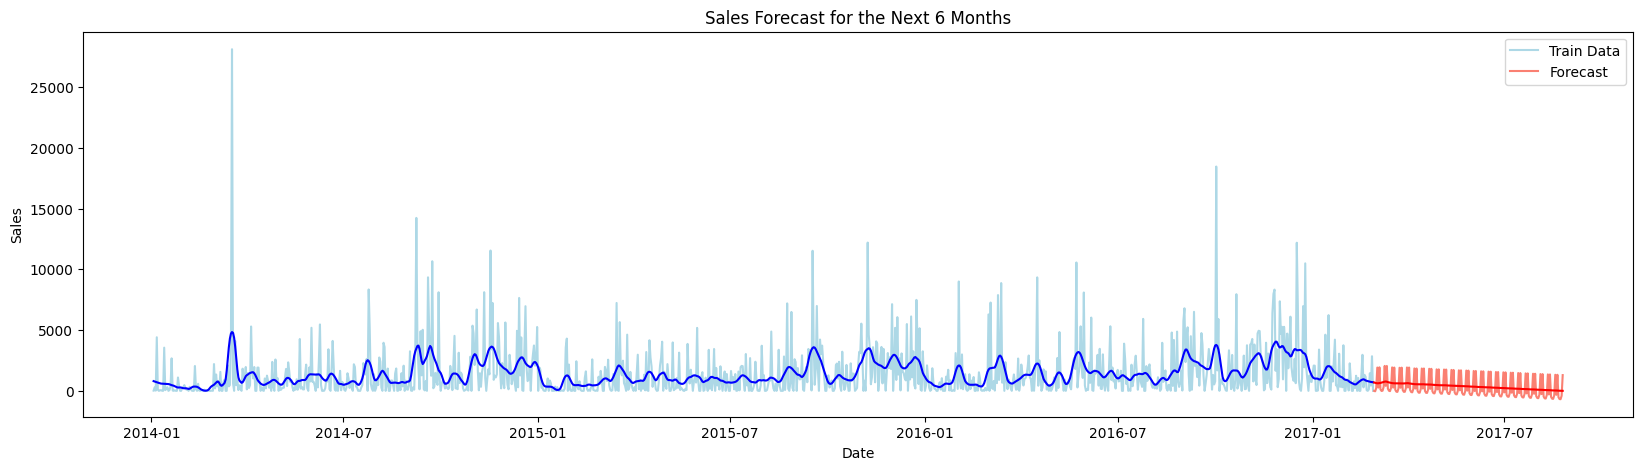

In [181]:
# Plot the forecasting
plt.subplots(figsize=(20, 5))

plt.plot(reconstructed.index, reconstructed['actual_values'], color='lightblue', label='Train Data')
plt.plot(forecast_df.index, forecast_df['forecast_s'], color='salmon', label='Forecast')
plt.plot(reconstructed.index, reconstructed['trend'], color='blue')
plt.plot(forecast_df.index, forecast_df['forecast'], color='red')

# plt.fill_between(forecast_df.index, 
#                  conf_int_df['lower_limit'], 
#                  conf_int_df['upper_limit'], 
#                  color='gray', alpha=0.3)

plt.title('Sales Forecast for the Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.show()